# Iterative and Conjugate Gradient Methods

When solving large linear systems, iterative methods are typically able to produce solutions that converge faster than do direct methods. This notebook provides an overview of the variety of iterative methods that have been developed including discussions of their rates of convergence:

1. Classical methods
    1. Jacobi
    2. Gauss-Seidel
    3. Successive over-relaxation (SOR)
    4. Symmetric successive over-relaxation (SSOR)
    5. Chebyshev
2. Krylov subspace methods
3. Conjugate gradient methods

This notebook is an important precursor to the 'Preconditioner Series' which assumes a working knowledge of iterative methods.

Many of the formulas and notations used are from [Matrix Computations by Gene H. Golub and Charles F. Van Loan (4th Ed.)](https://www.amazon.com/Computations-Hopkins-Studies-Mathematical-Sciences/dp/1421407949)

## Imports

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve_triangular
from sklearn.datasets import make_spd_matrix

%precision 5

'%.5f'

## Classical methods

### Jacobi method

For a 3-by-3 linear system $Ax=b$,

$$ \begin{bmatrix} a_{11} & a_{12} & a_{13} \\ a_{21} & a_{22} & a_{23} \\
a_{31} & a_{32} & a_{33} \end{bmatrix} \begin{bmatrix} x_1 \\ x_2 \\ x_3
\end{bmatrix} = \begin{bmatrix} b_1 \\ b_2 \\ b_3 \end{bmatrix} $$

the equation can be rearranged to express $x_1$, $x_2$, and $x_3$ in terms of the other variables:

$$ \begin{align} x_1 &= (b_1-a_{12}x_2-a_{13}x_3)/a_{11} \\ x_2 &= (b_2-a_{21}x_1-a_{23}x_3)/a_{22} \\ x_3 &= (b_3-a_{31}x_1-a_{32}x_2)/a_{33} \end{align} $$

All three equations have $x_i$ on both sides of the equal sign, and this can be interpreted as saying that the current approximation of $x_i$, $x_i^{(k-1)}$, is being used to calculate a new approximation of $x_i$, $x_i^{(k)}$. Rewritten the equations from above become:

$$ \begin{align} x_1^{(k)} &= (b_1-a_{12}x_2^{(k-1)}-a_{13}x_3^{(k-1)})/a_{11} \\ x_2^{(k)} &= (b_2-a_{21}x_1^{(k-1)}-a_{23}x_3^{(k-1)})/a_{22} \\ x_3^{(k)} &= (b_3-a_{31}x_1^{(k-1)}-a_{32}x_2^{(k-1)})/a_{33} \end{align} $$

These equations can be written in matrix form using three matrices $D_A$ (main diagonal), $L_A$ (lower triangular), and $U_A$ (upper triangular) such that $A=D_A+L_A+U_A$. Note that $L_A$ and $U_A$ do not include the main diagonal. 

Below is the linear system represented in matrix form:

$$ M_Jx^{(k)}=N_Jx^{(k-1)}+b $$

where $M_J=D_A$ and $N_J=-(L_A+U_A)$.

Rearranging the equation to calculate $x^{(k)}$ yields:

$$ x^{(k)}=M_J^{-1}(N_Jx^{(k-1)}+b) $$

In [55]:
def jacobi(A, x0, b, rtol=1e-5, atol=1e-8, max_iter=1000):
    
    # find inverse of diagonal matrix and off-diagonal matrix
    D_inv, R = np.diag(np.reciprocal(np.diagonal(A).astype(float))), A - np.diag(np.diagonal(A))
    
    i = 0
    x = np.array([x0])
    
    # loop for max_iter iterations or until converged
    while (i < max_iter):
        x = np.vstack((x, D_inv @ (b - R @ x[-1])))
        i += 1
        
        # test convergence
        if (np.allclose(x[-1], x[-2], rtol, atol)):
            print('Iterations:' + str(i))
            return x
        
    # solution did not converge
    print('Maximum number of iterations reached. Did not converge.')

Here, a linear system if defined for which the solution is known: $x=\begin{bmatrix} 1 & 2 & -1 & 1\end{bmatrix}$

In [56]:
A = np.array([[10., -1., 2., 0.],
              [-1., 11., -1., 3.],
              [2., -1., 10., -1.],
              [0.0, 3., -1., 8.]])

b = np.array([6., 25., -11., 15.])
x0 = np.ones_like(b)

x = jacobi(A, x0, b); x

Iterations:15


array([[ 1.    ,  1.    ,  1.    ,  1.    ],
       [ 0.5   ,  2.1818, -1.1   ,  1.625 ],
       [ 1.0382,  1.775 , -0.8193,  0.9193],
       [ 0.9414,  2.0419, -1.0382,  1.107 ],
       [ 1.0118,  1.962 , -0.9734,  0.9795],
       [ 0.9909,  2.0091, -1.0082,  1.0176],
       [ 1.0026,  1.9936, -0.9955,  0.9956],
       [ 0.9985,  2.0018, -1.0016,  1.0029],
       [ 1.0005,  1.9989, -0.9992,  0.9991],
       [ 0.9997,  2.0004, -1.0003,  1.0005],
       [ 1.0001,  1.9998, -0.9999,  0.9998],
       [ 1.    ,  2.0001, -1.0001,  1.0001],
       [ 1.    ,  2.    , -1.    ,  1.    ],
       [ 1.    ,  2.    , -1.    ,  1.    ],
       [ 1.    ,  2.    , -1.    ,  1.    ],
       [ 1.    ,  2.    , -1.    ,  1.    ]])

Plot solution evolution

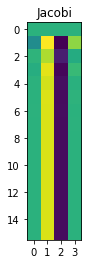

In [57]:
plt.imshow(x, interpolation='nearest');
plt.title('Jacobi')
plt.xticks(np.arange(len(b)));

### Gauss-Seidel method

The Gauss-Seidel method makes a small change to the Jacobi method: it uses the iterate previously calculated to calculate the next iterate. In other words, $x_1^{(k)}$ is plugged into the formula in place of $x_1^{(k-1)}$ to calculate $x_2^{(k)}$. Then, both $x_1^{(k)}$ and $x_2^{(k)}$ are used to calculate $x_3^{(k)}$.

In matrix form, the equations become:

$$ M_{GS}x^{(k)}=N_{GS}x^{(k-1)}+b $$

where $M_{GS}=D_A+L_A$ and $N_{GS}=-U_A$.

Because $M_{GS}$ is a lower triangular matrix, $x^{(k)}$ can be calculated  by forward substitution.

In [58]:
def gauss_seidel(A, x0, b, rtol=1e-5, atol=1e-8, max_iter=10000):
    M, N = np.tril(A), -np.triu(A, 1)
    
    i = 0
    x = np.array([x0])
    
    # loop for max_iter iterations or until converged
    while (i < max_iter):
        x = np.vstack((x, solve_triangular(M, N @ x[-1] + b, lower=True)))
        i += 1
            
        # test convergence
        if (np.allclose(x[-1], x[-2], rtol, atol)):
            print('Iterations:' + str(i))
            return x
        
    # solution did not converge
    print('Maximum number of iterations reached. Did not converge.')

The same linear system of equations is solved.

In [59]:
x = gauss_seidel(A, x0, b); x

Iterations:7


array([[ 1.    ,  1.    ,  1.    ,  1.    ],
       [ 0.5   ,  2.1364, -0.8864,  0.9631],
       [ 0.9909,  2.0196, -0.9999,  0.9927],
       [ 1.0019,  2.0022, -1.0009,  0.9991],
       [ 1.0004,  2.0002, -1.0002,  0.9999],
       [ 1.0001,  2.    , -1.    ,  1.    ],
       [ 1.    ,  2.    , -1.    ,  1.    ],
       [ 1.    ,  2.    , -1.    ,  1.    ]])

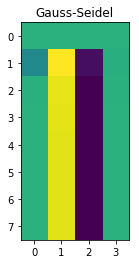

In [60]:
plt.imshow(x, interpolation='nearest');
plt.title('Gauss-Seidel');
plt.xticks(np.arange(len(b)));

### Successive over-relaxation (SOR)

In SSOR, $A$ is split such that $A=M_\omega - N_\omega$ where

$$ M_\omega = \frac{1}{\omega}D_A+L_A \ \ \ \ N_\omega = \bigg(\frac{1}{\omega}-1\bigg)D_A+U_A \ \ \ \ 0 < \omega \leq1$$

The matrix form of the equations is then

$$ \bigg(\frac{1}{\omega}D_A+L_A\bigg)x^{(k)} = \bigg(\bigg(\frac{1}{\omega}-1\bigg)D_A+U_A\bigg)x^{(k-1)}+b $$

For $\omega=1$, the SOR method is simply the Gauss-Seidel method.

In [61]:
def sor(A, x0, b, omega=0.5, rtol=1e-5, atol=1e-8, max_iter=10000):
    M, N = np.diag(np.diag(A)) / omega + np.tril(A, -1), (1 / omega - 1) * np.diag(np.diag(A)) - np.triu(A, 1)
    
    i = 0
    x = np.array([x0])
    
    # loop for max_iter iterations or until converged
    while (i < max_iter):
        x = np.vstack((x, solve_triangular(M, N @ x[-1] + b, lower=True)))
        i += 1
            
        # test convergence
        if (np.allclose(x[-1], x[-2], rtol, atol)):
            print('Iterations:' + str(i))
            return x
        
    # solution did not converge
    print('Maximum number of iterations reached. Did not converge.')

Here, the SOR method is run using a range of values for $\omega$.

In [62]:
omega = np.arange(0.1, 1, 0.1)
for o in omega:
    print('omega: ' + str(o))
    sor(A, x0, b, o)
    print()

omega: 0.1
Iterations:125

omega: 0.2
Iterations:64

omega: 0.30000000000000004
Iterations:42

omega: 0.4
Iterations:31

omega: 0.5
Iterations:23

omega: 0.6
Iterations:18

omega: 0.7000000000000001
Iterations:15

omega: 0.8
Iterations:12

omega: 0.9
Iterations:9



### Symmetric successive over-relaxation (SSOR)

In the case that $A$ is symmetric, SSOR can be used

In [ ]:
def ssor():

In [ ]:
x = ssor(A, x0, b); x

### Chebyshev method

In [ ]:
def chebyshev():

In [ ]:
x = chebyshev(A, x0, b); x

## Krylov subspace methods

### Conjugate gradient (CG) methods

CG methods are a classic set of methods applicable to **symmetric positive definite** systems. They can be derived through a variety of avenues: 

1. Steepest descent
2. Krylov subscpaces
3. Lanczos process
4. Tridiagonal system solving

For $Ax=b$ with $A$ being symmetric positive definite, the goal is to find $x$ such that the following optimization problem is solved:

$$ \min_{x \in \mathbb{R}^n} \frac{1}{2}x^TAx - x^Tb $$

#### Steepest descent with exact linear search

In [83]:
def steepest(A, x0, b, tau):
    x = np.array([x0])
    g = A @ x0 - b
    
    while (np.linalg.norm(g) > tau):
        mu = (g.T @ g) / (g.T @ A @ g) 
        x = np.vstack((x, x[-1] - mu * g))
        g = A @ x[-1] - b
    
    return x

In [90]:
A = make_spd_matrix(5)
b = np.random.rand(5)
x0 = np.ones_like(b)
tau = 1e-5

x = steepest(A, x0, b, tau); x

array([[ 1.     ,  1.     ,  1.     ,  1.     ,  1.     ],
       [ 1.33456,  1.0823 ,  0.10541,  0.39329,  0.48622],
       [ 1.6801 ,  1.66902,  0.75604,  0.32952, -0.25235],
       [ 1.71198,  1.67961,  0.66801,  0.2694 , -0.30139],
       [ 1.73811,  1.75884,  0.72915,  0.25763, -0.36265],
       [ 1.74131,  1.76006,  0.72003,  0.25137, -0.36761],
       [ 1.74323,  1.76933,  0.72606,  0.24971, -0.3731 ],
       [ 1.74356,  1.76946,  0.7251 ,  0.24905, -0.37362],
       [ 1.74369,  1.77048,  0.72572,  0.24883, -0.37415],
       [ 1.74372,  1.77049,  0.72562,  0.24876, -0.37421],
       [ 1.74373,  1.7706 ,  0.72568,  0.24873, -0.37426],
       [ 1.74374,  1.77061,  0.72567,  0.24873, -0.37427]])

In [94]:
A @ x[-1], b, np.allclose(A @ x[-1], b, atol=tau)

(array([0.73985, 0.8897 , 0.8563 , 0.41465, 0.02021]),
 array([0.73985, 0.88971, 0.8563 , 0.41464, 0.02021]),
 True)

#### Krylov subspace

#### Lanczos process

## Resources

[Matrix Computations by Gene H. Golub and Charles F. Van Loan (4th Ed.)](https://www.amazon.com/Computations-Hopkins-Studies-Mathematical-Sciences/dp/1421407949)